# 1. Install and import libraries..

In [1]:
!pip install graphviz

Requirement not upgraded as not directly required: graphviz in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages


In [2]:
!pip install xgboost --upgrade

Requirement already up-to-date: xgboost in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages
Requirement not upgraded as not directly required: numpy in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from xgboost)
Requirement not upgraded as not directly required: scipy in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from xgboost)


In [3]:
import gc
import time
import numpy as np
import pandas as pd
from sklearn.cross_validation import train_test_split
import xgboost as xgb
from xgboost import plot_importance
import matplotlib.pyplot as plt

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# 2. Read files and set schema

In [4]:
train_columns = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed']
test_columns  = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'click_id']
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }

In [5]:
# ANONYMIZED #
# Upload your train_sample.csv file and use Watson Studio's import to code feature to read it for there 

train = pd.read_csv(body, usecols=train_columns, dtype=dtypes)
train.head()



,ip,app,device,os,channel,click_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,0
1,105560,25,1,17,259,2017-11-07 13:40:27,0
2,101424,12,1,19,212,2017-11-07 18:05:24,0
3,94584,13,1,13,477,2017-11-07 04:58:08,0
4,68413,12,1,1,178,2017-11-09 09:00:09,0


In [30]:
# ANONYMIZED #
# Upload your test.csv file and use Watson Studio's import to code feature to read it for there 

test = pd.read_csv(body, usecols=test_columns, dtype=dtypes)
test.head()

,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,119901,9,1,3,466,2017-11-10 04:00:00
2,2,72287,21,1,19,128,2017-11-10 04:00:00
3,3,78477,15,1,13,111,2017-11-10 04:00:00
4,4,123080,12,1,13,328,2017-11-10 04:00:00


# 3. Feature engineering

### 3.1 Feature selection

Drop unwanted columns

In [7]:
y = train['is_attributed']
train.drop(['is_attributed'], axis=1, inplace=True)

In [8]:
sub = pd.DataFrame()
test.drop(['click_id'], axis=1, inplace=True)
gc.collect()

70

In [9]:
train.head()

,ip,app,device,os,channel,click_time
0,87540,12,1,13,497,2017-11-07 09:30:38
1,105560,25,1,17,259,2017-11-07 13:40:27
2,101424,12,1,19,212,2017-11-07 18:05:24
3,94584,13,1,13,477,2017-11-07 04:58:08
4,68413,12,1,1,178,2017-11-09 09:00:09


In [10]:
nrow_train = train.shape[0]
merge = pd.concat([train, test])

del train, test
gc.collect()

36

### 3.2 Create new features

##### Count the number of clicks by ip

In [11]:
ip_count = merge.groupby(['ip'])['channel'].count().reset_index()
ip_count.columns = ['ip', 'clicks_by_ip']
merge = pd.merge(merge, ip_count, on='ip', how='left', sort=False)
merge['clicks_by_ip'] = merge['clicks_by_ip'].astype('uint16')
merge.drop('ip', axis=1, inplace=True)

In [12]:
train = merge[:nrow_train]
test = merge[nrow_train:]
del test, merge
gc.collect()
train.head()

,app,device,os,channel,click_time,clicks_by_ip
0,12,1,13,497,2017-11-07 09:30:38,815
1,25,1,17,259,2017-11-07 13:40:27,3626
2,12,1,19,212,2017-11-07 18:05:24,299
3,13,1,13,477,2017-11-07 04:58:08,508
4,12,1,1,178,2017-11-09 09:00:09,1220


##### Generate time features

In [13]:
def timeFeatures(df):
    # Make some new features with click_time column
    df['datetime'] = pd.to_datetime(df['click_time'])
    df['dow']      = df['datetime'].dt.dayofweek
    df["doy"]      = df["datetime"].dt.dayofyear
    #df["dteom"]    = df["datetime"].dt.daysinmonth - df["datetime"].dt.day
    df.drop(['click_time', 'datetime'], axis=1, inplace=True)
    return df

In [14]:
train = timeFeatures(train)
gc.collect()

21

In [15]:
train[:10]

,app,device,os,channel,clicks_by_ip,dow,doy
0,12,1,13,497,815,1,311
1,25,1,17,259,3626,1,311
2,12,1,19,212,299,1,311
3,13,1,13,477,508,1,311
4,12,1,1,178,1220,3,313
5,3,1,17,115,499,3,313
6,1,1,17,135,1825,3,313
7,9,1,25,442,1381,1,311
8,2,2,22,364,5,2,312
9,3,1,19,135,1,2,312


##  4. Train a model

Now that we have our feature engineered data, we have a vast array of algorythms available to create our model (scikit-learn, xgboost, sparkML, tensorflow, H2O ...). It is a common thing to train several of these models and compare (or even combine) them in order to have the best possible solution.

Here we chose to just train an XGBoost model, which is a very fast and efficient way to compute "decision trees" (gradient boosted trees).

More info on what XGBoost is and why to use it there : https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/


### 4.1 Parameter tuning 

In [16]:
params = {'eval_metric': 'auc', 
          'grow_policy': "lossguide",
          'max_leaves': 1400,  
          'subsample': 0.9, 
          'colsample_bytree': 0.7, 
          'colsample_bylevel':0.7,
          'min_child_weight':0,
          'alpha':4,
          'silent': True}

These are the parameters of our model. they have been found using grid-search techniques, which usually implies to run the training for every possible combinations of parameters that seem relevant to the data scientist, based on intuition and experimentations.

It is very time consuming and intense computing-wise, so for the sake of this example, we will just assume that these are the optimal paremeters.

### 4.2 Model training and evaluation

In [17]:
x1, x2, y1, y2 = train_test_split(train, y, test_size=0.1, random_state=99)
dtrain = xgb.DMatrix(x1, y1)
dvalid = xgb.DMatrix(x2, y2)
del x1, y1, x2, y2 
gc.collect()
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
model = xgb.train(params, dtrain, 200, watchlist, maximize=True, early_stopping_rounds = 25, verbose_eval=5)
del dvalid
del dtrain
gc.collect()

[0]	train-auc:0.5	valid-auc:0.5
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 25 rounds.
[5]	train-auc:0.807181	valid-auc:0.782741
[10]	train-auc:0.938486	valid-auc:0.949445
[15]	train-auc:0.94909	valid-auc:0.953273
[20]	train-auc:0.959915	valid-auc:0.973731
[25]	train-auc:0.967625	valid-auc:0.966421
[30]	train-auc:0.968591	valid-auc:0.962366
[35]	train-auc:0.975919	valid-auc:0.960033
[40]	train-auc:0.975133	valid-auc:0.956295
[45]	train-auc:0.975526	valid-auc:0.952835
Stopping. Best iteration:
[20]	train-auc:0.959915	valid-auc:0.973731



21

##### Plot the feature importance from xgboost

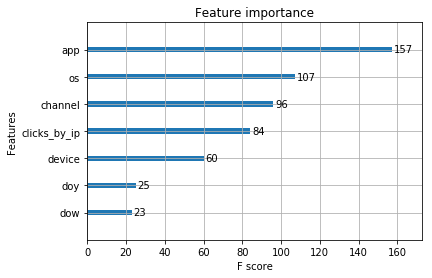

In [18]:
plot_importance(model)
plt.show()

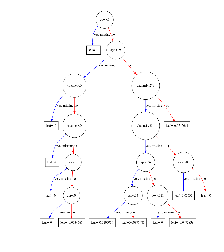

In [29]:
import matplotlib.pyplot as plt 
plt.style.use('ggplot') 
xgb.plot_tree(model, num_trees=2) 
xgb.to_graphviz(model, num_trees=2)
plt.show()

## 5. Make predictions

Now that we have trained a good model, let's use it to make prediction against the supplied test sample !

In [23]:
# ANONYMIZED #
# Upload your test.csv file and use Watson Studio's import to code feature to read it for there 
test = pd.read_csv(body, usecols=test_columns, dtype=dtypes)
test.head()

,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,119901,9,1,3,466,2017-11-10 04:00:00
2,2,72287,21,1,19,128,2017-11-10 04:00:00
3,3,78477,15,1,13,111,2017-11-10 04:00:00
4,4,123080,12,1,13,328,2017-11-10 04:00:00


In [24]:
test = pd.merge(test, ip_count, on='ip', how='left', sort=False)
del ip_count
gc.collect()

5543

Perform the same feature engineering actions we did on the training set

In [25]:
sub['click_id'] = test['click_id'].astype('int')
test['clicks_by_ip'] = test['clicks_by_ip'].astype('uint16')
test = timeFeatures(test)
test.drop(['click_id', 'ip'], axis=1, inplace=True)

In [26]:
dtest = xgb.DMatrix(test)
del test
gc.collect()

56

In [27]:
sub['is_attributed'] = model.predict(dtest, ntree_limit=model.best_ntree_limit)

In [28]:
sub

,click_id,is_attributed
0,0,0.000426
1,1,0.000574
2,2,0.000521
3,3,0.000254
4,4,0.000403
5,5,0.000254
6,6,0.000574
7,7,0.000521
8,9,0.000254
9,8,0.000213
